In [1]:
import csv
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,concatenate, Bidirectional,LeakyReLU
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [2]:
'''
Numerical features:
- Count of empty features
- Country of Issuer and Owner (Mapped)
- Organization of Issuer and Owner (Mapped)
- Signature Algorithm(Mapped)
- Difference between current and begin
- Difference between current and end
- Difference between end and begin

Textual features:
- CRL
- Domain CN (or) Hostname

Numerical features go through some machine learning based classifier
Textual features go through a LSTM based classifier
'''

'\nNumerical features:\n- Count of empty features\n- Country of Issuer and Owner (Mapped)\n- Organization of Issuer and Owner (Mapped)\n- Signature Algorithm(Mapped)\n- Difference between current and begin\n- Difference between current and end\n- Difference between end and begin\n\nTextual features:\n- CRL\n- Domain CN (or) Hostname\n\nNumerical features go through some machine learning based classifier\nTextual features go through a LSTM based classifier\n'

In [3]:
#For loading the data
prefix='Dataset/'
country={}
country_ct=0
org={}
org_ct=0
algo={}
algo_ct=0
curr= datetime.today()

def country_map(d_c):
    global country,country_ct
    if d_c in country:
        d_c = country[d_c]
    else:
        country[d_c]=country_ct
        d_c=country_ct
        country_ct+=1
    return d_c

def algo_map(d_c):
    global algo,algo_ct
    if d_c in algo:
        d_c = algo[d_c]
    else:
        algo[d_c]=algo_ct
        d_c=algo_ct
        algo_ct+=1
    return d_c

def org_map(d_c):
    global org,org_ct
    if d_c in org:
        d_c = org[d_c]
    else:
        org[d_c]=org_ct
        d_c=org_ct
        org_ct+=1
    return d_c

def data_load_p(start,end):
    crl_arr,dcn_arr,num_arr,icn_arr,snos=[],[],[],[],set()
    for i in range(start,end+1):
        rfile_name='pt_cert_mod'+str(i)+'.csv'
        with open(prefix+rfile_name, newline='') as f:
            reader = csv.reader(f)
            for row in reader:
                (no,d_c,d_o,cn,i_c,i_o,i_cn,ver,sno,alg,end,begin,target,d_cn)=row[:14]
                crl=row[14]if len(row)>14 else "N/A" 
                ct=len([i for i in row if (i==None or i=="")])+ (1 if crl==None or crl=='N/A' else 0)
                d_cn = d_cn.replace("http://","").replace("https://","").replace("www","")
                #d_c = country_map(d_c)
                #i_c = country_map(i_c)
                #d_o = org_map(d_o)
                #i_o = org_map(i_o)
                #alg = algo_map(alg)              
                begin = datetime.strptime(begin[2:-2], '%Y%m%d%H%M%S')
                end = datetime.strptime(end[2:-2], '%Y%m%d%H%M%S')
                diff_cb=int((curr-begin).total_seconds()//3600)
                diff_ce=int((end-curr).total_seconds()//3600)
                diff_eb=int((end-begin).total_seconds()//3600)
                num_arr.append((d_c,i_c,d_o,i_o,alg))
                crl_arr.append(crl.replace("\n","").replace("http://",""))
                dcn_arr.append(d_cn)
                icn_arr.append(i_cn)
    return (num_arr,crl_arr,dcn_arr,icn_arr)
                
                
def data_load_a(start,end):
    crl_arr,dcn_arr,num_arr,icn_arr=[],[],[],[]    
    for i in range(start,end+1):
        rfile_name='alexa_certs'+str(i)+'.csv'
        with open(prefix+rfile_name, newline='') as f:
            reader = csv.reader(f)
            for row in reader:
                (no,d_c,d_o,d_cn,i_c,i_o,i_cn,ver,sno,alg,end,begin)=row[:12]
                crl=row[12]if len(row)>12 else "N/A"                   
                ct=len([i for i in row if (i==None or i=="")])+ (1 if crl==None or crl=='N/A' else 0)
                #d_c = country_map(d_c)
                #i_c = country_map(i_c)
                #d_o = org_map(d_o)
                #i_o = org_map(i_o)
                #alg = algo_map(alg)
                begin = datetime.strptime(begin[2:-2], '%Y%m%d%H%M%S')
                end = datetime.strptime(end[2:-2], '%Y%m%d%H%M%S')
                diff_cb=int((curr-begin).total_seconds()//3600)
                diff_ce=int((end-curr).total_seconds()//3600)
                diff_eb=int((end-begin).total_seconds()//3600)
                num_arr.append((d_c,i_c,d_o,i_o,alg))
                crl_arr.append(crl.replace("\n","").replace("http://",""))
                dcn_arr.append(d_cn)
                icn_arr.append(i_cn)
    return (num_arr,crl_arr,dcn_arr,icn_arr)
                

In [4]:
(pnum_data,pcrl,pdcn,picn)=data_load_p(1,15)
(anum_data,acrl,adcn,aicn)=data_load_a(1,1)

In [5]:
ptext_data=pdcn
atext_data=adcn
Xdcn=np.array(ptext_data+atext_data[:len(ptext_data)])
Ydcn=np.array(len(ptext_data)*[0]+len(ptext_data)*[1])
Xdcn_train,Xdcn_test,Y_train,Y_test = train_test_split(Xdcn,Ydcn,test_size=0.30,random_state=24)

In [6]:
ptext_data=picn
atext_data=aicn
Xicn=np.array(ptext_data+atext_data[:len(ptext_data)])
Yicn=np.array(len(ptext_data)*[0]+len(ptext_data)*[1])
Xicn_train,Xicn_test,Y_train,Y_test = train_test_split(Xicn,Yicn,test_size=0.30,random_state=24)

In [7]:
ptext_data=pcrl
atext_data=acrl
Xcrl=np.array(ptext_data+atext_data[:len(ptext_data)])
Ycrl=np.array(len(ptext_data)*[0]+len(ptext_data)*[1])
Xcrl_train,Xcrl_test,Ycrl_train,Ycrl_test = train_test_split(Xcrl,Ycrl,test_size=0.30,random_state=24)

In [8]:
#One-hot encoding of numerical values
onehotencoder = OneHotEncoder()
Xnum=np.array(pnum_data+anum_data[:len(pnum_data)])
Xnum = onehotencoder.fit_transform(Xnum).toarray()
Ynum=np.array(len(pnum_data)*[0]+len(pnum_data)*[1])
Xnum_train,Xnum_test,Y_train,Y_test = train_test_split(Xnum,Ynum,test_size=0.30,random_state=24)
in3len=Xnum.shape[1]

In [9]:
#Setting params and tokenizing text content
max_words = 1000
max_len = 30
tokcn = Tokenizer(num_words=max_words,filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokcn.fit_on_texts(Xdcn_train)
sequences_dcn = tokcn.texts_to_sequences(Xdcn_train)
sequencesdcn_matrix = sequence.pad_sequences(sequences_dcn,maxlen=max_len)

In [10]:
tokcn.fit_on_texts(Xicn_train)
sequences_icn = tokcn.texts_to_sequences(Xicn_train)
sequencesicn_matrix = sequence.pad_sequences(sequences_icn,maxlen=max_len)

In [11]:
tokcrl = Tokenizer(num_words=max_words,filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokcrl.fit_on_texts(Xcrl_train)
sequences_crl = tokcrl.texts_to_sequences(Xcrl_train)
sequencescrl_matrix = sequence.pad_sequences(sequences_crl,maxlen=max_len)

In [12]:
#Definition of the model 
def RNN():
    inputs1 = Input(name='inputs1',shape=[max_len])
    layer1 = Embedding(max_words,50,input_length=max_len)(inputs1)
    layer1 = LSTM(max_len)(layer1)
    layer1 = Dense(max_len//2,name='Dense-DCN-I')(layer1)
    layer1 = LeakyReLU(alpha=0.1)(layer1)
    layer1 = Dropout(0.5)(layer1)
    layer1 = Dense(8,name='Dense-DCN-F')(layer1)
    layer1 = LeakyReLU(alpha=0.1)(layer1)
    model1 = Model(inputs=inputs1,outputs=layer1)
    
    inputs2 = Input(name='inputs2',shape=[max_len])
    layer2 = Embedding(max_words,50,input_length=max_len)(inputs2)
    layer2 = Bidirectional(LSTM(max_len))(layer2)
    layer2 = Dense(max_len//2,name='Dense-DCRL-I')(layer2)
    layer2 = LeakyReLU(alpha=0.1)(layer2)
    layer2 = Dropout(0.5)(layer2)
    layer2 = Dense(8,name='Dense-DCRL-F')(layer2)
    layer2 = LeakyReLU(alpha=0.1)(layer2)
    model2 = Model(inputs=inputs2,outputs=layer2)
        
    inputs4 = Input(name='inputs4',shape=[max_len])
    layer4 = Embedding(max_words,50,input_length=max_len)(inputs4)
    layer4 = LSTM(max_len)(layer4)
    layer4 = Dense(max_len//2,name='Dense-ICN-I')(layer4)
    layer4 = LeakyReLU(alpha=0.1)(layer4)
    layer4 = Dropout(0.5)(layer4)
    layer4 = Dense(8, activation='relu',name='Dense-ICN-F')(layer4)
    layer4 = LeakyReLU(alpha=0.1)(layer4)
    model4 = Model(inputs=inputs4,outputs=layer4)
    
    inputs3 = Input(name='input3',shape=(in3len,))
    layer3 = Dense(512,name='Dense-NUM-I')(inputs3)
    layer4 = LeakyReLU(alpha=0.2)(layer4)
    layer3 = Dropout(0.5)(layer3)
    layer3 = Dense(8,name='Dense-NUM-F')(layer3)
    layer3 = LeakyReLU(alpha=0.2)(layer3)
    model3 = Model(inputs=inputs3,outputs=layer3)
    
    layer = concatenate([model1.output,model2.output,model3.output,model4.output])
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=[inputs1,inputs2,inputs3,inputs4],outputs=layer)
    return model

In [13]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
inputs2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
inputs4 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 50)       50000       inputs1[0][0]                    
_______________________________________________________________________________________

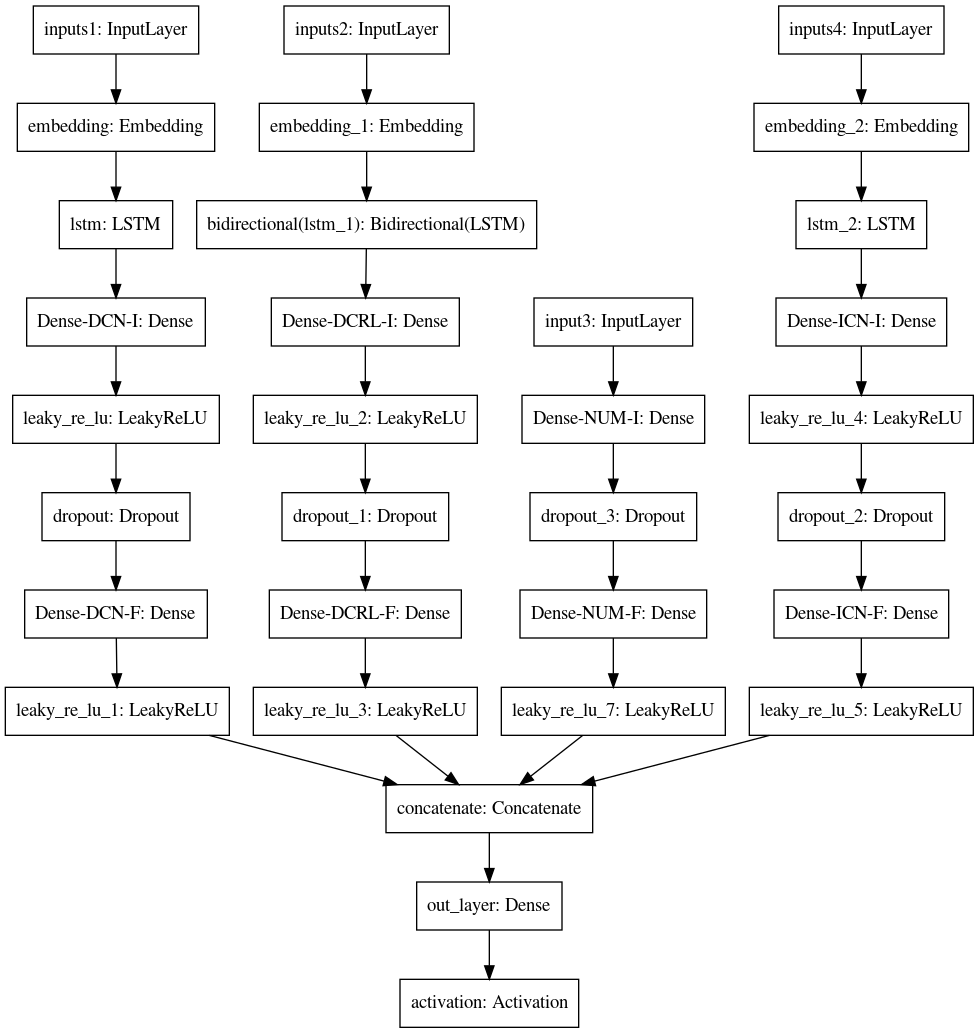

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [15]:
history = model.fit([sequencesdcn_matrix,sequencescrl_matrix,Xnum_train,sequencesicn_matrix],Y_train,batch_size=256,epochs=10,
          validation_split=0.2)

Epoch 1/10
1050/1050 [==============================] - 48s 46ms/step - loss: 0.2830 - accuracy: 0.8774 - val_loss: 0.2517 - val_accuracy: 0.8771
Epoch 2/10
1050/1050 [==============================] - 43s 41ms/step - loss: 0.2260 - accuracy: 0.9014 - val_loss: 0.2205 - val_accuracy: 0.9025
Epoch 3/10
1050/1050 [==============================] - 43s 41ms/step - loss: 0.2196 - accuracy: 0.9029 - val_loss: 0.2177 - val_accuracy: 0.9041
Epoch 4/10
1050/1050 [==============================] - 43s 41ms/step - loss: 0.2168 - accuracy: 0.9044 - val_loss: 0.2162 - val_accuracy: 0.9048
Epoch 5/10
1050/1050 [==============================] - 43s 41ms/step - loss: 0.2156 - accuracy: 0.9053 - val_loss: 0.2161 - val_accuracy: 0.9053
Epoch 6/10
1050/1050 [==============================] - 43s 41ms/step - loss: 0.2147 - accuracy: 0.9054 - val_loss: 0.2188 - val_accuracy: 0.9053
Epoch 7/10
1050/1050 [==============================] - 43s 41ms/step - loss: 0.2141 - accuracy: 0.9061 - val_loss: 0.2159 -

In [16]:
testdcn_sequences = tokcn.texts_to_sequences(Xdcn_test)
testdcn_sequences_matrix = sequence.pad_sequences(testdcn_sequences,maxlen=max_len)
testicn_sequences = tokcn.texts_to_sequences(Xicn_test)
testicn_sequences_matrix = sequence.pad_sequences(testicn_sequences,maxlen=max_len)
testcrl_sequences = tokcrl.texts_to_sequences(Xcrl_test)
testcrl_sequences_matrix = sequence.pad_sequences(testcrl_sequences,maxlen=max_len)

In [17]:
accr = model.evaluate([testdcn_sequences_matrix,testcrl_sequences_matrix,Xnum_test,testicn_sequences_matrix],Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2249/2249 [==============================] - 10s 4ms/step - loss: 0.7647 - accuracy: 0.7632
Test set
  Loss: 0.765
  Accuracy: 0.763


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
testX=[testdcn_sequences_matrix,testcrl_sequences_matrix,Xnum_test,testicn_sequences_matrix]
yhat_probs = model.predict(testX, verbose=0)
yhat_classes=(yhat_probs > 0.5).astype(np.int)
yhat_probs = yhat_probs[:, 0]
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
precision = precision_score(Y_test, yhat_classes)
print('Precision: %f' % precision)
recall = recall_score(Y_test, yhat_classes)
print('Recall: %f' % recall)

Accuracy: 0.763177
Precision: 0.783997
Recall: 0.726659


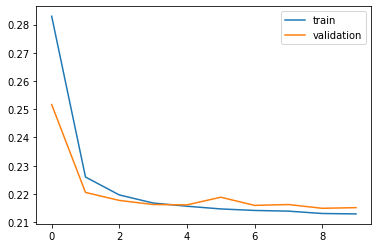

In [29]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()

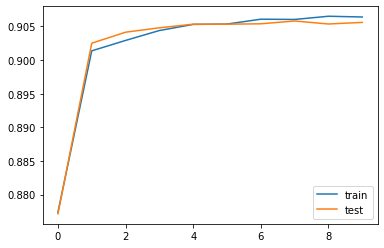

In [26]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()